# Deep Learning Part C

- Name: Javon Low
- Admin Number: 2214452
- Class: DMAD/FT/2B/01

## Objective

To Experiment the use of Decision Trees in the context of Q-Learning.

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import plot_tree
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

In [2]:
class MLP(nn.Module):
    def __init__(self, inp, out, lr):
        super(MLP, self).__init__()
        
        self.layer1 = nn.Linear(inp, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, out)
        
        self.lr = lr
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)
        
    def forward(self, x):
        x = self.layer1(x)
        x = F.leaky_relu(x)
        x = self.layer2(x)
        x = F.leaky_relu(x)
        x = self.layer3(x)
        x = F.leaky_relu(x)
        return self.layer4(x)

In [3]:
class Memory(object):

    def __init__(self, maxlen):
        self.buffer = deque([], maxlen=maxlen)
    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        mini_batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states = [], [], [], []
        # perform some manipulation to ensure dtypes match
        for transition in mini_batch:
            s, a, r, ns = transition
            states.append(s) # s is a tensor not a regular element
            actions.append([a])
            rewards.append([r])
            next_states.append(ns)
        
        states = torch.stack(states)
        actions = torch.tensor(actions, dtype=torch.float)
        rewards = torch.tensor(rewards, dtype=torch.float)
        next_states = torch.stack(next_states)
        return states, actions, rewards, next_states
    
    def get_all(self): # for decision tree training
        mini_batch = random.sample(self.buffer, len(self.buffer))
        return mini_batch
    
    def __len__(self):
        return len(self.buffer)

In [75]:
class DoubleDQNAgent:
    def __init__(self, depth=None, numOfAction= 20, action_array=np.concatenate(((-1 *( np.exp(np.linspace(0, 1.09, 10)) - 1))[::-1], np.exp(np.linspace(0, 1.09, 10)) - 1)).tolist()):
        self.steps = 0
        self.memory = Memory(10000)
        
        # Greedy Episilon Hyperparams
        self.epsilon       = 1.0
        self.epsilon_decay = 0.98
        self.epsilon_min   = 0.001

        self.batch_size = 256
        self.adamlr = 0.001
        self.targetlr = 0.01
        self.gamma = 0.98
        
        self.numOfAction = numOfAction
        self.action_array = action_array

        self.policy_net = MLP(3, self.numOfAction,self.adamlr)
        self.target_net = MLP(3, self.numOfAction,self.adamlr)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        if depth is not None:
            self.interpreter = MultiOutputRegressor(DecisionTreeRegressor(max_depth=depth))
        else:
            self.interpreter = MultiOutputRegressor(DecisionTreeRegressor())

    def transform_choice(self, num):
        return self.action_array[int(num)]
    
    def action(self,state):

        sample = np.random.rand()
        
        if sample > self.epsilon:
            with torch.no_grad():
                choice = float(torch.argmax(self.policy_net(state)).numpy())
                action = self.transform_choice(choice)
        else:
            choice = np.random.choice([n for n in range(self.numOfAction)])
            action = self.transform_choice(choice)
            
        return choice, action
    
    def optimize(self):
        if len(self.memory) < self.batch_size:
            return
        
        batch = self.memory.sample(self.batch_size)
        state, action, reward, next_state = batch
        action = action.type(torch.int64)
        
        with torch.no_grad():
            expected_q = self.target_net(next_state).max(1)[0].unsqueeze(1)
            expected = reward + self.gamma * expected_q

        # Actual values - Policy Net
        actual = self.policy_net(state).gather(1,action)
        
        # Back_propagation
        loss = F.smooth_l1_loss(actual, expected)
        self.policy_net.optimizer.zero_grad()
        loss.mean().backward()
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), 0.5)
        self.policy_net.optimizer.step()
        
        for target_param,param in zip(self.target_net.parameters(),self.policy_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.targetlr) + param.data * self.targetlr)
    
    def fit_interpreter(self):
        batch = self.memory.get_all()
        X = []
        targets = []
        for state, action, reward, state_next in batch:
            with torch.no_grad():
                q_values = self.policy_net(state).numpy()
            X.append(list(state.numpy()))
            targets.append(q_values)
        #print(len(X), len(targets))
        self.interpreter.fit(X, targets)

In [79]:
def train_model_eps(DQNAgentX, episodes, verbose=True, **args):
    agent = DQNAgentX(**args)
    env = gym.make('Pendulum-v1')
    score_list = []
    for episode in range(episodes):
        if verbose:
            print(f"Episode: {episode}",end="")
        state, _ = env.reset()
        state = torch.tensor(state)
        done = False
        score = 0
        while not done:
            choice, action = agent.action(state)
            
            next_state, reward, terminated, truncated, _ = env.step([action])
            
            score+=reward
            done = terminated or truncated
            
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state,dtype=torch.float32)
                
            agent.memory.push((state, choice, reward, next_state ))
            state = next_state
            
            if len(agent.memory) > 1000:  
                agent.optimize()
        if verbose:
            print(f", Score: {score}, Threshold: {agent.epsilon}")
        else:
            print("|", end="")
        score_list.append(score)

        if agent.epsilon > agent.epsilon_min:
                agent.epsilon *= agent.epsilon_decay
        
        if episode == episodes -1:
            agent.fit_interpreter()
    env.close()
    print("")
    plt.plot(score_list)
    plt.show()

    return agent, score_list

Episode: 0, Score: -1371.757437760104, Threshold: 1.0
Episode: 1, Score: -1485.4688794431497, Threshold: 0.98
Episode: 2, Score: -988.3238344814287, Threshold: 0.9603999999999999
Episode: 3, Score: -1808.0119778606077, Threshold: 0.9411919999999999
Episode: 4, Score: -1162.3509705279484, Threshold: 0.9223681599999999
Episode: 5, Score: -1053.766101239269, Threshold: 0.9039207967999998
Episode: 6, Score: -866.2978265079527, Threshold: 0.8858423808639998
Episode: 7, Score: -980.8003616303631, Threshold: 0.8681255332467198
Episode: 8, Score: -1564.340020479192, Threshold: 0.8507630225817854
Episode: 9, Score: -1541.1926189590083, Threshold: 0.8337477621301497
Episode: 10, Score: -979.6216320421396, Threshold: 0.8170728068875467
Episode: 11, Score: -1107.5809728725117, Threshold: 0.8007313507497957
Episode: 12, Score: -890.9815993676992, Threshold: 0.7847167237347998
Episode: 13, Score: -823.0576406609509, Threshold: 0.7690223892601038
Episode: 14, Score: -1125.2482251086888, Threshold: 0.

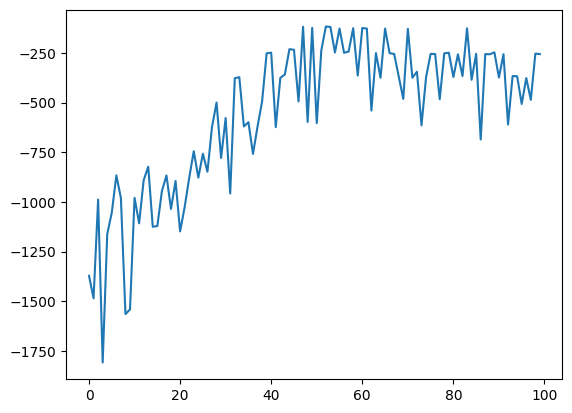

In [84]:
agent, score = train_model_eps(DoubleDQNAgent,100)

Text(0.5, 0, 'Trees in MultOutput Regressor')

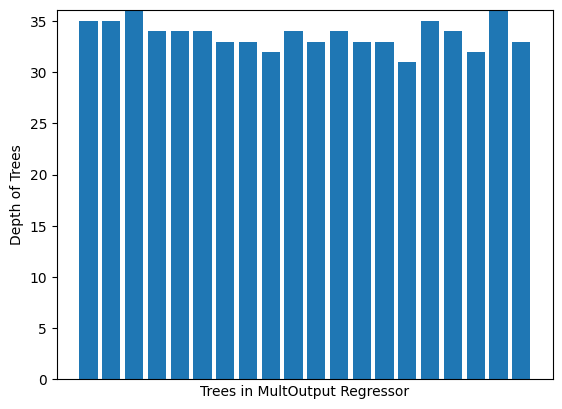

In [95]:
regressors = agent.interpreter.estimators_
depths = [i.get_depth() for i in regressors]
plt.bar(range(len(depths)),depths)
plt.ylim(0, max(depths) + 0.1)
plt.xticks([])
plt.ylabel("Depth of Trees")
plt.xlabel("Trees in MultOutput Regressor")

In [48]:
def evaluate_tree(agent,episodes, tree=False):
    env = gym.make('Pendulum-v1')
    scores = []
    for i in range(episodes):
        #print(f"Episode: {i}",end="")
        state = env.reset()[0]
        tempState = torch.tensor(state)
        state = np.reshape(state, [1, 3])
        score = 0
        while True:
            #env.render()
            if not tree:
                choice = np.random.uniform(-2.0,2.0)
                action = float((choice-4)/2)
            else:
                q_vals = agent.predict(state)
                choice = np.argmax(q_vals)
                action = float((choice-4)/2)

            state_next, reward, terminated, truncated, _ = env.step([action])
            #print(reward)
            score += reward
            state_next = np.reshape(state_next, [1, 3])
            if tree or random:
                state = state_next
            else:
                state = None if terminated else torch.tensor(state_next, dtype=torch.float32)
            if terminated or truncated:
                #print(" score: " + str(score))
                break
        scores.append(score)
    print(f"Average Score: {np.mean(scores)}")
    return np.mean(scores), scores

In [49]:
def evaluate_model(agent, episodes):

    # Initialize Pendulum environment for visualization
    env_visualize = gym.make('Pendulum-v1')
    scores = []
    # Visualization loop
    for episode in range(episodes):
        #print(f"Evaluating Episode: {episode+1}", end="")
        
        # Reset the environment for a new episode
        state, info = env_visualize.reset()
        state = torch.tensor(state)
        
        done = False
        score = 0
        
        # Episode simulation loop
        while not done:
            # Render the environment (visualize the Pendulum)
            
            # Choose an action using the trained DQNAgent
            choice, action = agent.action(state)
            
            # Take a step in the environment
            next_state, reward, terminated, truncated, _ = env_visualize.step([action])
            
            # Update the total score
            score += reward
            done = terminated or truncated
            
            # If the episode is terminated, set next_state to None; otherwise, convert it to a tensor
            next_state = None if terminated else torch.tensor(next_state, dtype=torch.float32)
            
            state = next_state
        
        scores.append(score)
        # Print episode score
        #print(f", Score: {score}")
    print(f"Final Score: {np.mean(scores)}")
    # Close the visualization environment after visualizing
    env_visualize.close()
    return np.mean(scores), scores

In [57]:
agentTotal, agentScore = evaluate_model(agent,200)
treeTotal, treeScore = evaluate_tree(agent.interpreter,200, tree=True)
randomTotal, randomScore = evaluate_tree(agent.interpreter,200)

Final Score: -243.65802644681594
Average Score: -260.42264645244626
Average Score: -1402.4457210870178


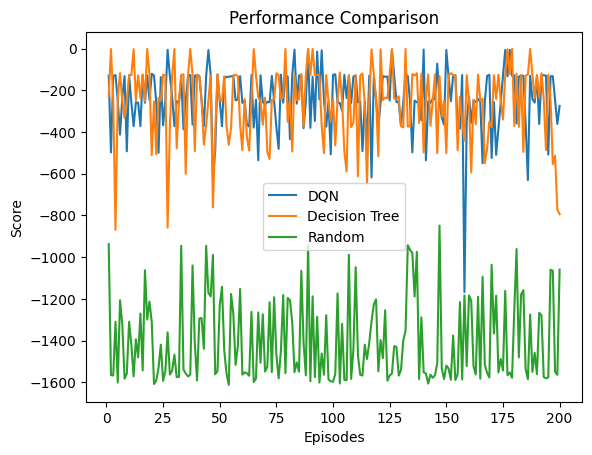

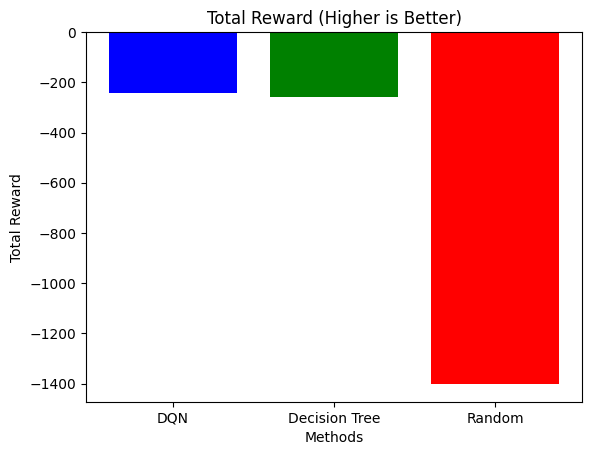

In [59]:
# Line graph for scores
episodes = np.arange(1, len(agentScore) + 1)
plt.plot(episodes, agentScore, label='DQN')
plt.plot(episodes, treeScore, label='Decision Tree')
plt.plot(episodes, randomScore, label='Random')

plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Performance Comparison')
plt.legend()

plt.show()

# Bar graph for totals
methods = ['DQN', 'Decision Tree', 'Random']
totals = [agentTotal, treeTotal, randomTotal]

plt.bar(methods, totals, color=['blue', 'green', 'red'])
plt.xlabel('Methods')
plt.ylabel('Total Reward')
plt.title('Total Reward (Higher is Better)')

plt.show()

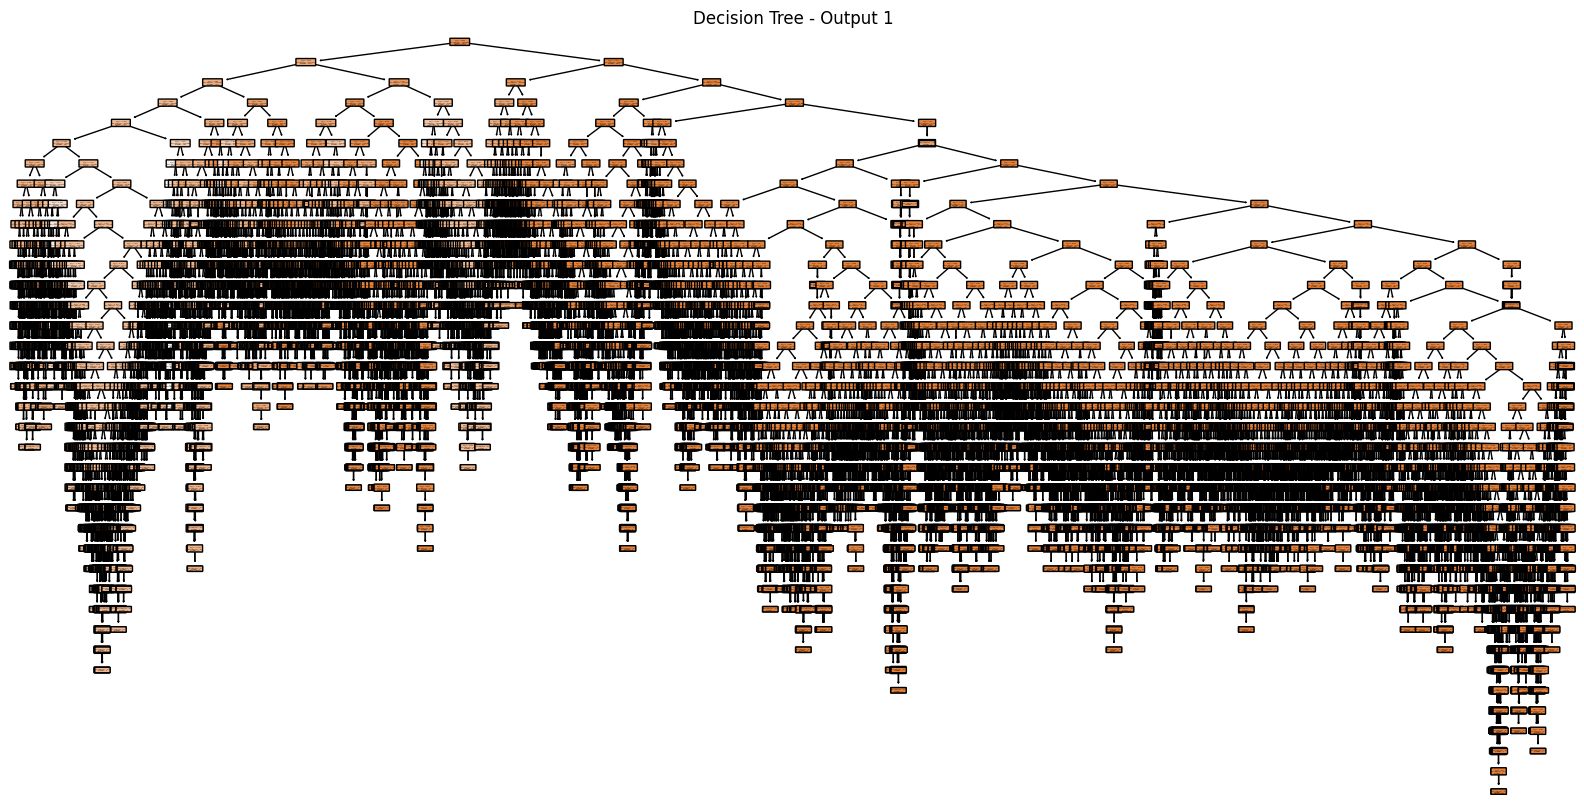

In [60]:
plt.figure(figsize=(20, 10))
plot_tree(agent.interpreter.estimators_[0],
          filled=True,
          rounded=True)
plt.title('Decision Tree - Output 1')
plt.show()

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||10000 10000



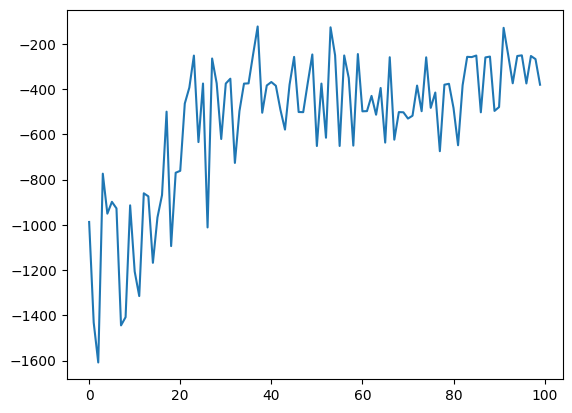

Final Score: -331.99607698177584
Average Score: -1468.8961863661677


In [80]:
less_agent, less_score = train_model_eps(DoubleDQNAgent,100, verbose=False, depth=5)

agentTotal, agentScore = evaluate_model(less_agent,200)
treeTotal, treeScore = evaluate_tree(less_agent.interpreter,200, tree=True)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||10000 10000



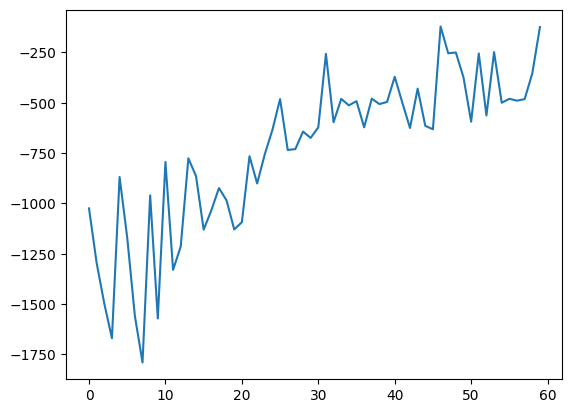

Final Score: -254.01394584365767
Average Score: -1570.573164105098
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||10000 10000



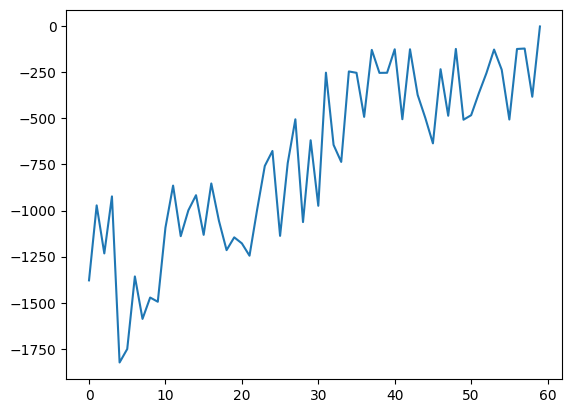

Final Score: -215.026652634745
Average Score: -873.1812008324165
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||10000 10000



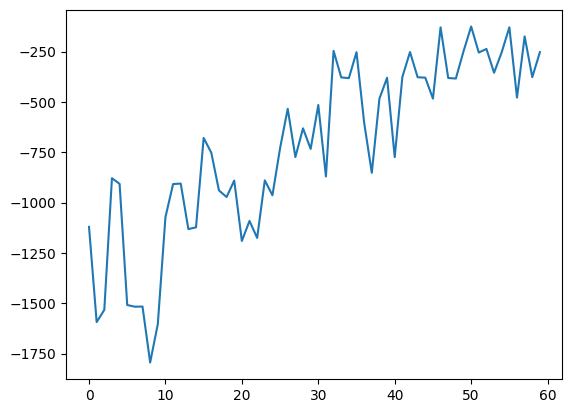

Final Score: -265.6066170943435
Average Score: -206.52405684969904
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||10000 10000



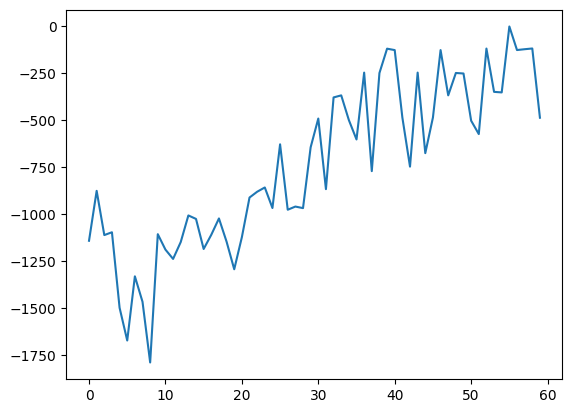

Final Score: -264.6860375745971
Average Score: -829.6971174526739
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||10000 10000



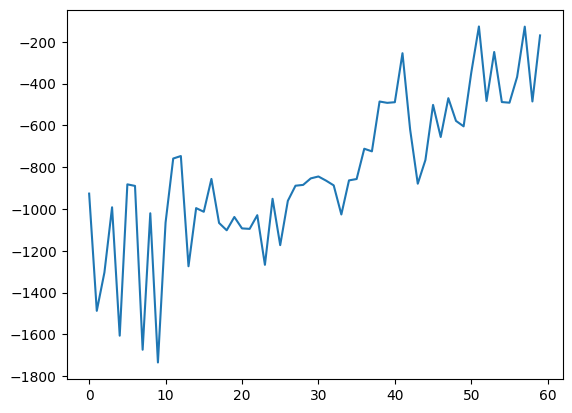

Final Score: -266.0914983278612
Average Score: -219.61269713188128


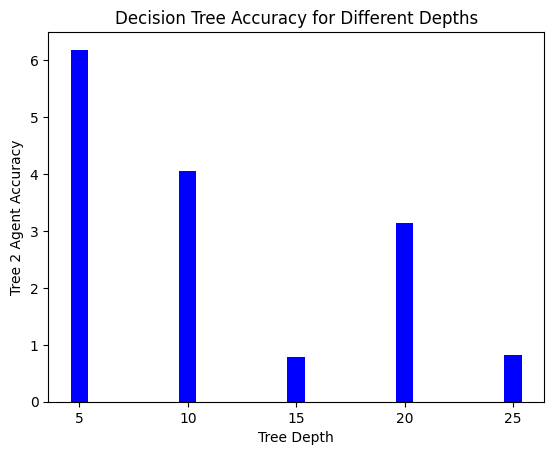

In [107]:

depth_values = list(range(5, 30,5))
tree_accuracies = []

for depth in depth_values:
    agent, _ = train_model_eps(DoubleDQNAgent, 60, verbose=False, depth=depth)
    agent_score, _ = evaluate_model(agent, 100)
    tree_score, _ = evaluate_tree(agent.interpreter, 100, tree=True)

    tree_accuracy = tree_score / agent_score
    tree_accuracies.append(tree_accuracy)


# Plot the results
plt.bar(depth_values, tree_accuracies, color='blue')
plt.xlabel('Tree Depth')
plt.ylabel('Tree 2 Agent Accuracy')
plt.title('Decision Tree Accuracy for Different Depths')
plt.show()

In [97]:
agent.interpreter.estimators_[0].feature_importances_

array([0.61224433, 0.06099909, 0.32675658])

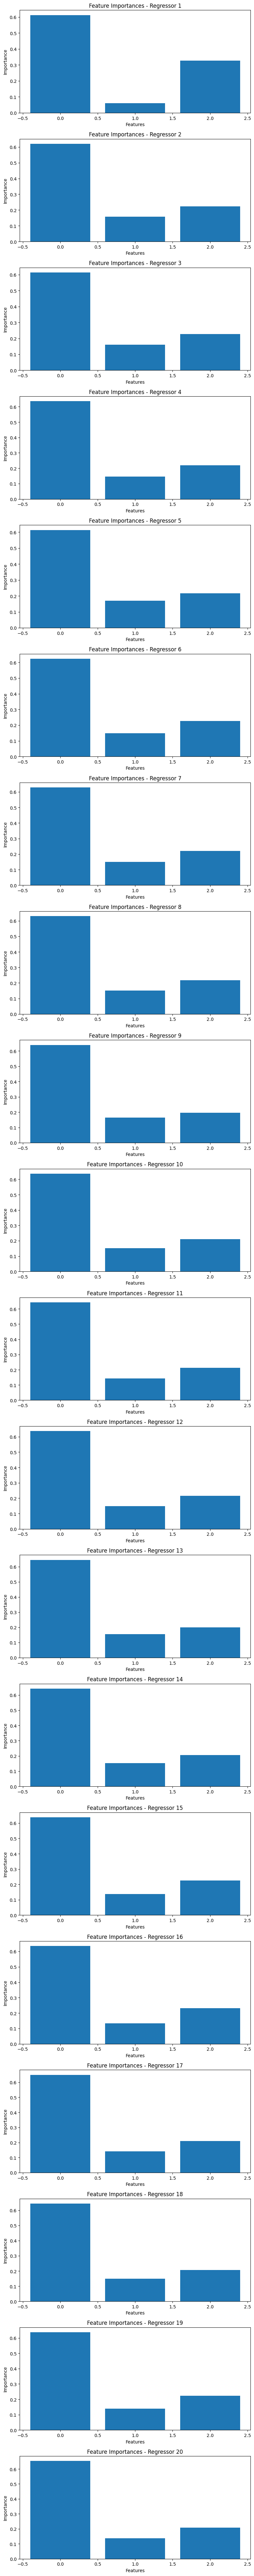

In [98]:
fig, axes = plt.subplots(len(agent.interpreter.estimators_), 1, figsize=(8, 4 * len(agent.interpreter.estimators_)))

for i, regressor in enumerate(agent.interpreter.estimators_):
    feature_importances = regressor.feature_importances_
    axes[i].bar(range(len(feature_importances)), feature_importances)
    axes[i].set_xlabel('Features')
    axes[i].set_ylabel('Importance')
    axes[i].set_title(f'Feature Importances - Regressor {i+1}')

plt.tight_layout()
plt.show()

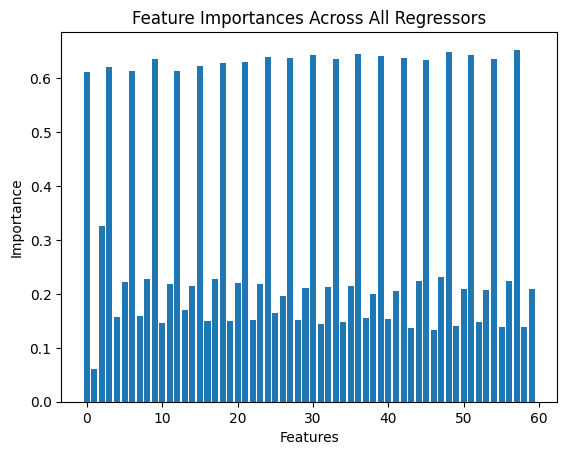

In [100]:
all_feature_importances = np.concatenate([regressor.feature_importances_ for regressor in agent.interpreter.estimators_])

# Plot feature importances for all regressors
plt.bar(range(len(all_feature_importances)), all_feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances Across All Regressors')
plt.show()

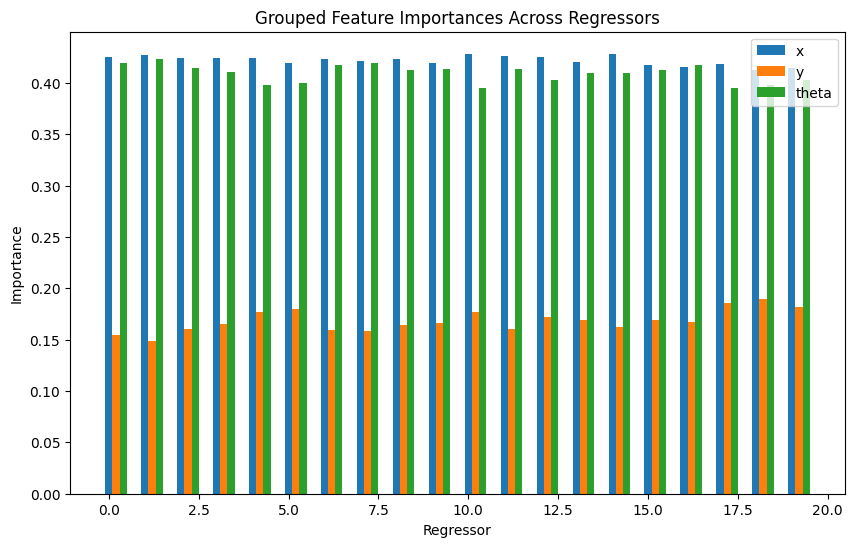

In [109]:
width = 0.2  # Adjust the width as needed
fig, ax = plt.subplots(figsize=(10, 6))
all_feature_importances = np.array([regressor.feature_importances_ for regressor in agent.interpreter.estimators_])
features = ["x", "y","theta"]
for i in range(all_feature_importances.shape[1]):
    x = np.arange(all_feature_importances.shape[0]) + i * width
    ax.bar(x, all_feature_importances[:, i], width=width, label=f'{features[i]}')

ax.set_xlabel('Regressor')
ax.set_ylabel('Importance')
ax.set_title('Grouped Feature Importances Across Regressors')
ax.legend()

plt.show()

In [105]:
tree = agent.interpreter.estimators_[0].tree_

# Prune the tree by setting a maximum depth
max_depth = 3
children_left, children_right = tree.children_left, tree.children_right
stack = [(0, -1)]  # (node, parent)
while stack:
    node, parent = stack.pop()
    if parent >= 0 and tree.feature[parent] == -2:  # Prune the subtree
        children_left[parent] = children_right[parent] = -1
    if tree.children_left[node] != -1:
        stack.append((tree.children_left[node], node))
    if tree.children_right[node] != -1:
        stack.append((tree.children_right[node], node))

# Plot the pruned decision tree
plt.figure(figsize=(12, 8))
plot_tree(agent.interpreter.estimators_[0], filled=True, feature_names=[f"Feature {i}" for i in range(3)], rounded=True)
plt.title('Pruned Decision Tree')
plt.show()

KeyboardInterrupt: 